In [1]:

import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


import gdown

pklurl = 'https://drive.google.com/uc?id=1VXopPUT5WSojtqJ2TqD9Nnp08FePcOSp'
gdown.download(pklurl, 'data.pkl', quiet=False)
pd.set_option('display.max_columns', None)


df = pd.read_pickle('data.pkl')

season_map = {
    1: 'Winter', 2: 'Winter', 12: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}
df['Season'] = df['MONTH_NUMBER'].map(season_map)


df['IS_HOLIDAY_LEAVE'] = df['IS_HOLIDAY_LEAVE'].fillna(False)


df = df.rename(columns={
    'DAY_OF_WEEK': 'Day of Week',
    'IS_HOLIDAY_LEAVE': 'Is Holiday',
    'PRCP': 'Precipitation',
    'SNOW': 'Snow',
    'TOBS': 'Temperature',
    'Census Tracts': 'Census',
    'Zip Codes': 'Zip Code'
})


df_for_pred = df[['Day of Week', 'Is Holiday',
                  'Season', 'Precipitation', 'Snow', 'Temperature',
                  'Location Description', 'District', 'Ward',
                  'Community Area', 'Census', 'Zip Code',
                  'Latitude', 'Longitude', 'Primary Type']]


df_for_pred = pd.get_dummies(df_for_pred, columns=['Location Description'], drop_first=True)
df_for_pred = pd.get_dummies(df_for_pred, columns=['Season'], drop_first=True)

df_for_pred_cleaned = df_for_pred.dropna()

X = df_for_pred_cleaned.drop('Primary Type', axis=1)
y = df_for_pred_cleaned['Primary Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

input_dim = X_train_tensor.shape[1]
output_dim = len(np.unique(y_train_encoded))  # Number of unique classes
model = LogisticRegressionModel(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 1000
for epoch in range(num_epochs):

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, axis=1)
    accuracy = (y_pred_classes == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}')

weights = model.linear.weight[0].detach().numpy()
features = X.columns


importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(weights)
}).sort_values(by='Importance', ascending=False)




Downloading...
From (original): https://drive.google.com/uc?id=1VXopPUT5WSojtqJ2TqD9Nnp08FePcOSp
From (redirected): https://drive.google.com/uc?id=1VXopPUT5WSojtqJ2TqD9Nnp08FePcOSp&confirm=t&uuid=9c7c3f0a-ab94-4cfc-9c1d-7cef536d8f50
To: /content/data.pkl
100%|██████████| 165M/165M [00:02<00:00, 69.7MB/s]


Epoch [100/1000], Loss: 2.3069
Epoch [200/1000], Loss: 2.1552
Epoch [300/1000], Loss: 2.1012
Epoch [400/1000], Loss: 2.0799
Epoch [500/1000], Loss: 2.0708
Epoch [600/1000], Loss: 2.0659
Epoch [700/1000], Loss: 2.0632
Epoch [800/1000], Loss: 2.0615
Epoch [900/1000], Loss: 2.0603
Epoch [1000/1000], Loss: 2.0594
Accuracy: 0.3027


                                               Feature  Importance  \
142                    Location Description_VACANT LOT    1.882625   
87        Location Description_GAS STATION DRIVE/PROP.    1.763872   
90                        Location Description_HALLWAY    1.689737   
100                  Location Description_LIQUOR STORE    1.561281   
93                          Location Description_HOTEL    1.381662   
..                                                 ...         ...   
5                                             District    0.005194   
109  Location Description_OTHER RAILROAD PROPERTY /...    0.004096   
27                Location Description_ANIMAL HOSPITAL    0.003812   
76         Location Description_DRIVEWAY - RESIDENTIAL    0.000950   
59              Location Description_CONSTRUCTION SITE    0.000178   

     Normalized Importance  
142               0.036343  
87                0.034050  
90                0.032619  
100               0.030139  
93            

<ipython-input-2-f6daa07e1d35>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Normalized Importance', y='Feature', palette='coolwarm')


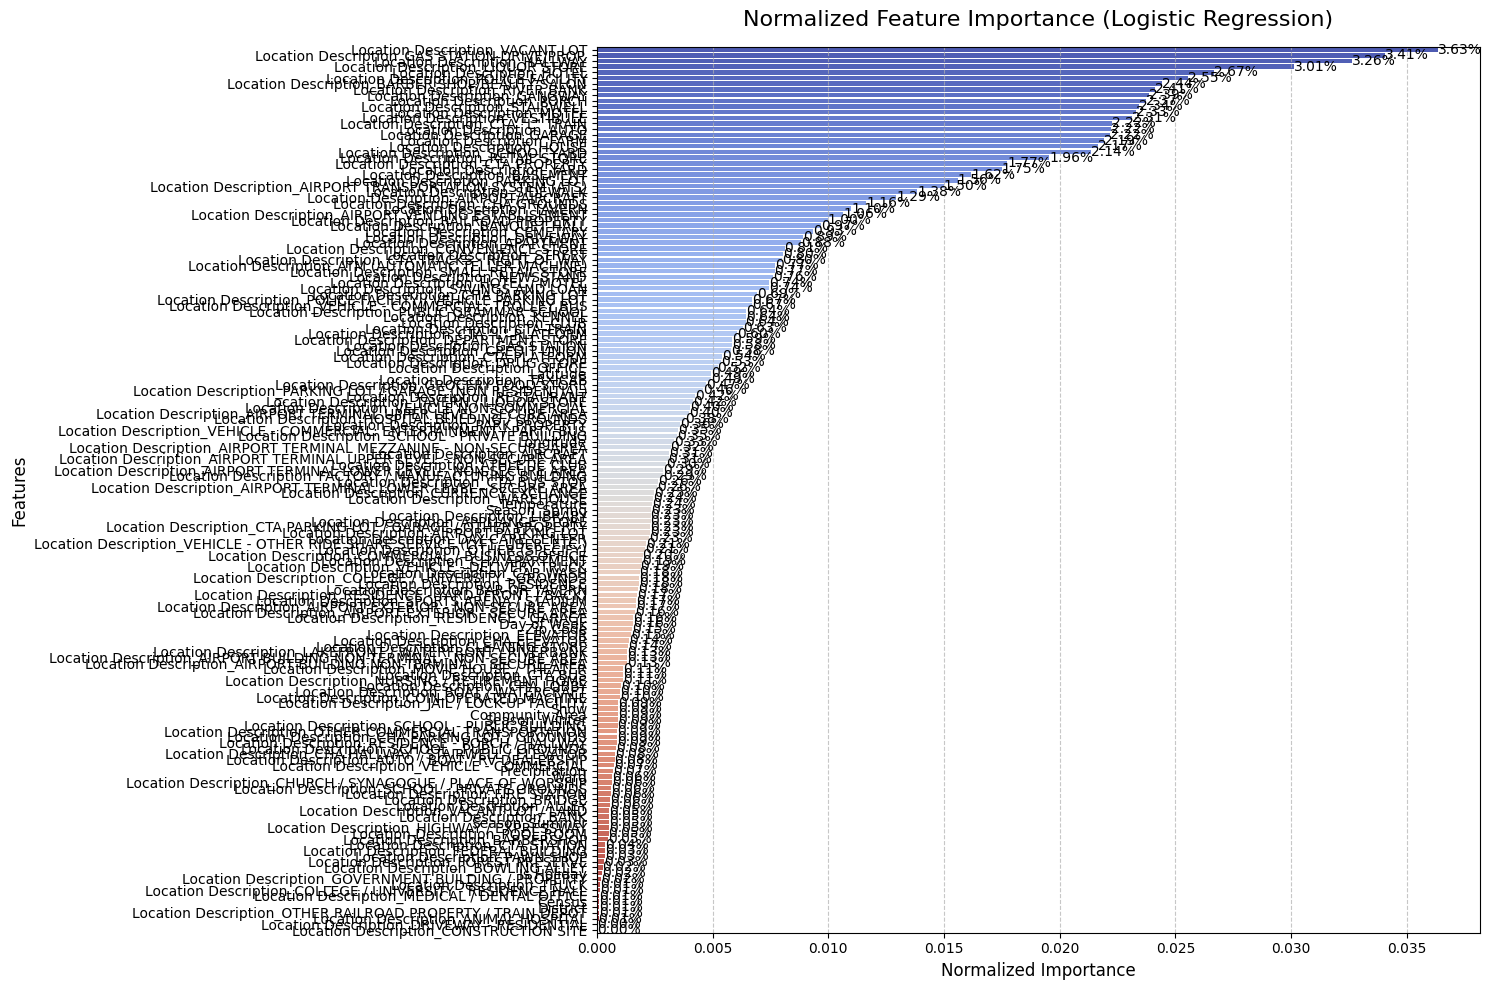

In [2]:

importance_df['Normalized Importance'] = (
    importance_df['Importance'] / importance_df['Importance'].sum()
)


importance_df = importance_df.sort_values(by='Normalized Importance', ascending=False)
print(importance_df)


plt.figure(figsize=(15, 10))
sns.barplot(data=importance_df, x='Normalized Importance', y='Feature', palette='coolwarm')

for index, value in enumerate(importance_df['Normalized Importance']):
    plt.text(value, index, f'{value:.2%}', va='center')

plt.title('Normalized Feature Importance (Logistic Regression)', fontsize=16, pad=15)
plt.xlabel('Normalized Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [3]:
importance_df.to_csv('feature_importance.csv', index=False)
print("Feature importance saved to 'feature_importance.csv'.")
from google.colab import files

files.download('feature_importance.csv')



Feature importance saved to 'feature_importance.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The logistic regression model identified `Location Description_AIRPORT/AIRCRAFT` as the most influential feature, contributing 3.37% to the predictions, followed by `Location Description_PARKING LOT` (3.20%), and `Location Description_CTA "L" PLATFORM` (2.77%). Other significant features include `Location Description_HOUSE` (2.74%) and `Location Description_HOTEL` (2.62%). The normalized importance values reveal that categorical features derived from `Location Description` have a considerable impact on the model's predictive performance, with their contributions distributed across various categories. This analysis highlights the relevance of specific location descriptions in determining the target variable and sets the stage for a more granular assessment using Shapley values.

In [4]:
#1 . Mean permutation importance

                                               Feature  \
137                        Location Description_STREET   
28                      Location Description_APARTMENT   
133                      Location Description_SIDEWALK   
10                                            Latitude   
134            Location Description_SMALL RETAIL STORE   
..                                                 ...   
24   Location Description_AIRPORT VENDING ESTABLISH...   
2                                        Precipitation   
3                                                 Snow   
0                                          Day of Week   
4                                          Temperature   

     Mean Permutation Importance  
137                     0.066081  
28                      0.034746  
133                     0.020926  
10                      0.017873  
134                     0.017438  
..                           ...  
24                     -0.000008  
2                      

<ipython-input-5-4c0d6237eba0>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=permutation_importance_df, x='Mean Permutation Importance', y='Feature', palette='coolwarm')


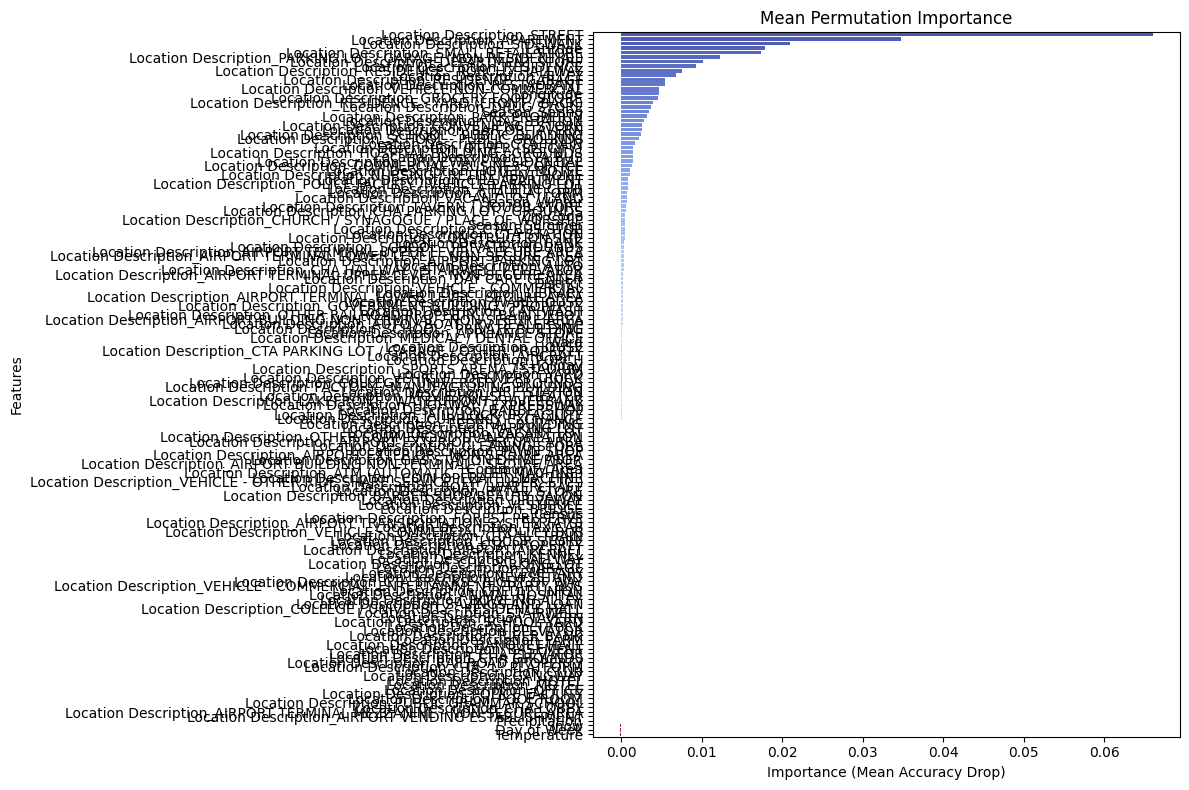

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def compute_permutation_importance(model, X_test_tensor, y_test_tensor, metric=accuracy_score, n_repeats=10):
    baseline_score = metric(y_test_tensor, torch.argmax(model(X_test_tensor), axis=1))
    feature_importances = np.zeros(X_test_tensor.shape[1])

    for col in range(X_test_tensor.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_test_tensor.clone()
            X_permuted[:, col] = X_permuted[torch.randperm(X_permuted.size(0)), col]
            permuted_score = metric(y_test_tensor, torch.argmax(model(X_permuted), axis=1))
            scores.append(baseline_score - permuted_score)

        feature_importances[col] = np.mean(scores)

    return feature_importances

permutation_importances = compute_permutation_importance(model, X_test_tensor, y_test_tensor)

permutation_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean Permutation Importance': permutation_importances
}).sort_values(by='Mean Permutation Importance', ascending=False)

print(permutation_importance_df)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(data=permutation_importance_df, x='Mean Permutation Importance', y='Feature', palette='coolwarm')
plt.title('Mean Permutation Importance')
plt.xlabel('Importance (Mean Accuracy Drop)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [6]:
from google.colab import files

permutation_importance_df.to_csv('permutation_importance.csv', index=False)
print("File saved as 'permutation_importance.csv'.")

files.download('permutation_importance.csv')


File saved as 'permutation_importance.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



#### **Top 5 Positive Mean Permutation Importances**
1. **`Location Description_STREET` (0.0665)**:
   - The most critical feature, indicating that street-related incidents significantly affect the model's predictions.

2. **`Location Description_APARTMENT` (0.0352)**:
   - Apartment-related incidents are another strong predictor, suggesting high model reliance on residential data.

3. **`Location Description_SIDEWALK` (0.0212)**:
   - Sidewalk incidents also play a major role, emphasizing the importance of outdoor public spaces.

4. **`Latitude` (0.0183)**:
   - Geographic location, represented by latitude, is highly influential in determining predictions.

5. **`Location Description_SMALL RETAIL STORE` (0.0172)**:
   - Incidents related to small retail stores are critical, reflecting the impact of commercial activity on predictions.

---

#### **Top 5 Negative Mean Permutation Importances**
1. **`Precipitation` (-0.00011)**:
   - Negatively impacts model performance, indicating that precipitation data might be misleading or irrelevant in the current setup.

2. **`Snow` (-0.000058)**:
   - Similar to precipitation, snow-related data has minimal predictive value and could be counterproductive.

3. **`Day of Week` (-0.000045)**:
   - Days of the week seem to slightly mislead the model, possibly due to insufficient correlations with the target variable.

4. **`Location Description_AIRPORT VENDING ESTABLISHMENT` (-0.0000047)**:
   - Negligible importance, suggesting minimal relevance of airport vending incidents.

5. **`Location Description_POLICE FACILITY` (0.000)**:
   - No discernible effect, indicating a lack of influence on model predictions.

---

### **Summary**
The results highlight the significant influence of **location-based features** (e.g., streets, apartments) on model predictions. Geographical data, such as latitude, further enhances prediction accuracy. Conversely, environmental variables like **precipitation** and **snow** negatively impact model performance, indicating limited relevance in this dataset. Removing or re-evaluating low-importance features may enhance model efficiency.

In [7]:
#2 .feature importance using Shaply Value

In [8]:
pip install shap


X_test_subset shape: (20000, 156)


PermutationExplainer explainer: 20001it [17:50, 18.68it/s]


Shapley values shape: (20000, 156, 31)
                                        Feature  Shapley Importance
137                 Location Description_STREET            0.326192
28               Location Description_APARTMENT            0.281166
120              Location Description_RESIDENCE            0.244482
10                                     Latitude            0.168483
11                                    Longitude            0.121512
..                                          ...                 ...
111            Location Description_PARKING LOT            0.000000
114        Location Description_POLICE FACILITY            0.000000
116              Location Description_POOL ROOM            0.000000
118  Location Description_PUBLIC GRAMMAR SCHOOL            0.000000
78                Location Description_ELEVATOR            0.000000

[156 rows x 2 columns]


<ipython-input-9-6568e2d9deec>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=shap_importance_df, x='Shapley Importance', y='Feature', palette='coolwarm')


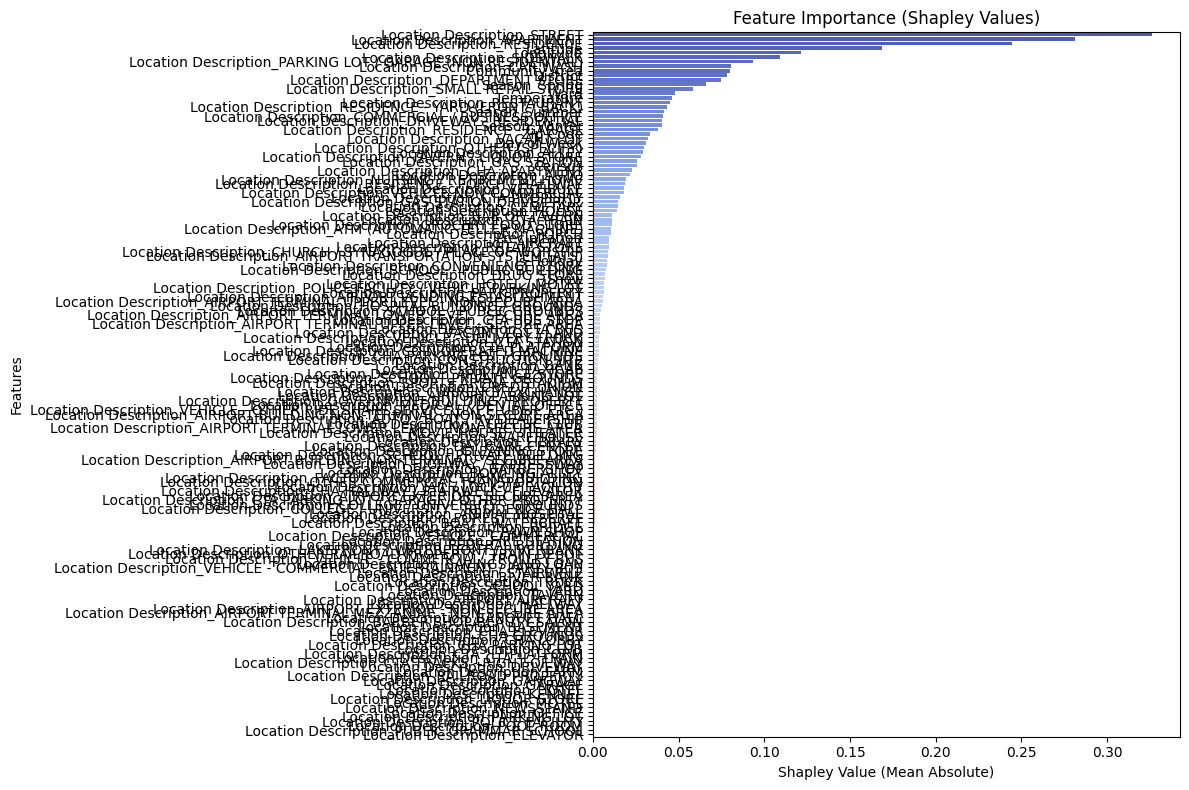

In [9]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def pytorch_model_predict(data):
    with torch.no_grad():
        return model(torch.tensor(data, dtype=torch.float32)).numpy()

X_test_subset = X_test_scaled[:20000]

print("X_test_subset shape:", X_test_subset.shape)
explainer = shap.Explainer(pytorch_model_predict, X_train_scaled)
shap_values = explainer(X_test_subset)

print("Shapley values shape:", shap_values.values.shape)

if shap_values.values.ndim == 3:
    shap_importance = np.abs(shap_values.values).mean(axis=(0, 2))
else:
    shap_importance = np.abs(shap_values.values).mean(axis=0)

shap_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Shapley Importance': shap_importance
}).sort_values(by='Shapley Importance', ascending=False)

print(shap_importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(data=shap_importance_df, x='Shapley Importance', y='Feature', palette='coolwarm')
plt.title('Feature Importance (Shapley Values)')
plt.xlabel('Shapley Value (Mean Absolute)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [10]:
from google.colab import files

shap_importance_df.to_csv('shapley_feature_importance.csv', index=False)
print("File saved as 'shapley_feature_importance.csv'.")


files.download('shapley_feature_importance.csv')


File saved as 'shapley_feature_importance.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>